In [1]:
import sys
import os

ROOT = "/scratch/rasera/FE"
sys.path.append(os.path.join(ROOT, "Scripts"))

from setup import *

In [ ]:
import subprocess

engine = "python"
procs = []
args_list = [
    [engine, f"{ROOT}/FE/Scripts/FE_calc.py", "TN6", "NI2", "10"],
    [engine, f"{ROOT}/FE/Scripts/FE_calc.py", "TN6", "NI2", "100"],
    [engine, f"{ROOT}/FE/Scripts/FE_calc.py", "TN6", "NI2", "1000"],
    # Add more as needed
]

for args in args_list:
    procs.append(subprocess.Popen(args))

# Wait for all to finish
for p in procs:
    p.wait()

In [ ]:
%run /scratch/rasera/FE/Scripts/Press_calc.py

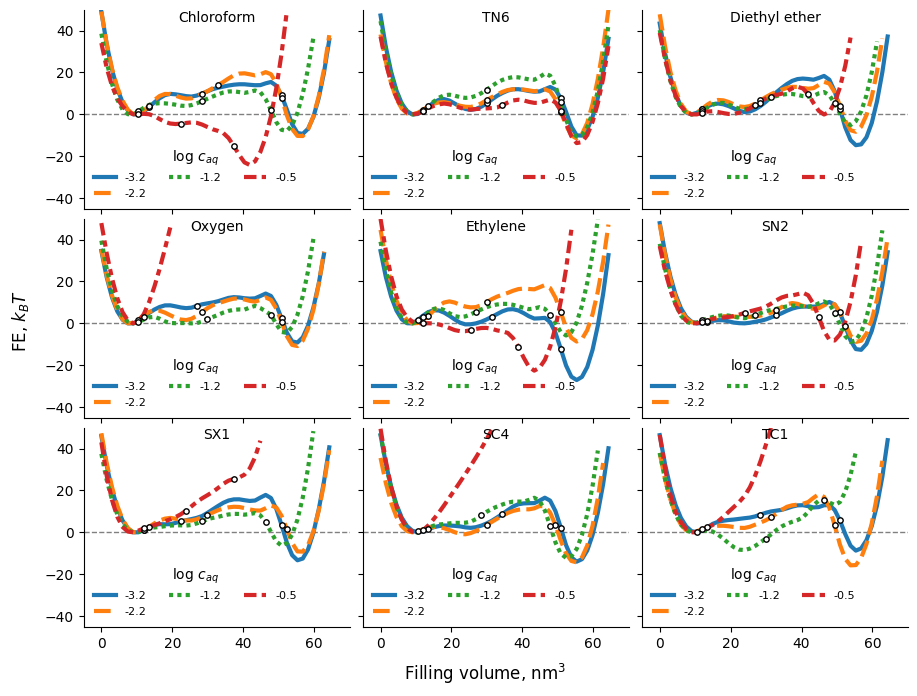

In [7]:
from FE_calc import extrapolate_FE
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv(f'{ROOT}/FE/outfiles/FE_all.csv')
ps = pd.read_csv(f'{ROOT}/FE/outfiles/inf_points_all.csv')

# Filter data
df = df[df['FE'] <= 50]
df = df[(df["ngas"] != 0) | (df["mol"] == "No gas")]
df = df[~df['mol'].isin(['Bare', 'Fullerene', 'N2'])]
ps = ps[~ps['mol'].isin(['Bare', 'Fullerene', 'N2'])]
df = df[df['ngas'].isin([10,100,1000,5000])]
ps = ps[ps['ngas'].isin([10,100,1000,5000])]

#df_cut = extrapolate_FE(df, n_extrap=6)
#df_cut.to_csv(f'{ROOT}/FE/outfiles/FE_all_cut.csv', index=False)

df['vol'] = df.groupby(['mol', 'ngas'])['coord'].transform(lambda x: x - x.min())
min_coords = df.groupby(['mol', 'ngas'])['coord'].min().reset_index()
min_coords.rename(columns={'coord': 'coord_min'}, inplace=True)
ps = ps.merge(min_coords, on=['mol', 'ngas'], how='left')
ps[['x_int', 'x_int_1', 'x_ext']] = ps[['x_int', 'x_int_1', 'x_ext']].sub(ps['coord_min'], axis=0)
ps.drop(columns=['coord_min'], inplace=True)

df['log_c'] = df['C'].apply(lambda x: np.log10(x)).round(1)
df.loc[df['mol'] == 'No gas', 'log_c'] = 0

# Define a function to plot inflection points.
def scatter_inflection(ax, molecule, **kwargs):
    # Get subset of inflection points for the specific molecule in the current subplot
    subset_ps = ps[ps["mol"] == molecule]
    if not subset_ps.empty:
        sns.scatterplot(data=subset_ps, x="x_int", y="y_int", ax=ax,
                        facecolor="white", edgecolor="black", marker="o", zorder=10, **kwargs)
        sns.scatterplot(data=subset_ps, x="x_int_1", y="y_int_1", ax=ax,
                        facecolor="white", edgecolor="black", marker="o", zorder=10, **kwargs)
        sns.scatterplot(data=subset_ps, x="x_ext", y="y_ext", ax=ax,
                        facecolor="white", edgecolor="black", marker="o", zorder=10, **kwargs)

g = sns.FacetGrid(df, col='mol', col_wrap=3, sharex=True, sharey=True, height=2.3, aspect=1.3)
g.refline(y=0, linestyle='--', color='gray', lw=1, zorder=-1)

for ax, mol in zip(g.axes.flat, df['mol'].unique()):
    subset = df[df['mol'] == mol]

    is_legend = False if 'No gas' in subset["mol"].unique() else True

    sns.lineplot(data=subset, x="vol", y="FE", hue="log_c", style="log_c", 
                 palette='tab10', lw=3, ax=ax, legend=is_legend)

    molecule = mol
    scatter_inflection(ax, molecule, lw=1, s=15)

    if is_legend:
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, title='log $c_{aq}$', fontsize=8, title_fontsize=10, 
                  handlelength=2, loc='lower left', frameon=False, ncol=3)

# Set common axis labels and facet titles.
g.set_axis_labels("", "")
g.set_titles("{col_name}")

# Optionally, adjust axis limits and ticks
g.set(xlim=np.array([-5, 70]))
g.set(ylim=np.array([-45, 50]))
g.figure.supylabel("FE, $k_BT$", x=-0.03)
g.figure.supxlabel("Filling volume, nm$^3$", y=-0.03)

g.set_titles(col_template="{col_name}", loc='center', y=0.9)
g.fig.subplots_adjust(hspace=0.05, wspace=0.05)

# Save the figure
g.figure.savefig(f'{ROOT}/FE/plots/FEs_all.png', dpi=300)


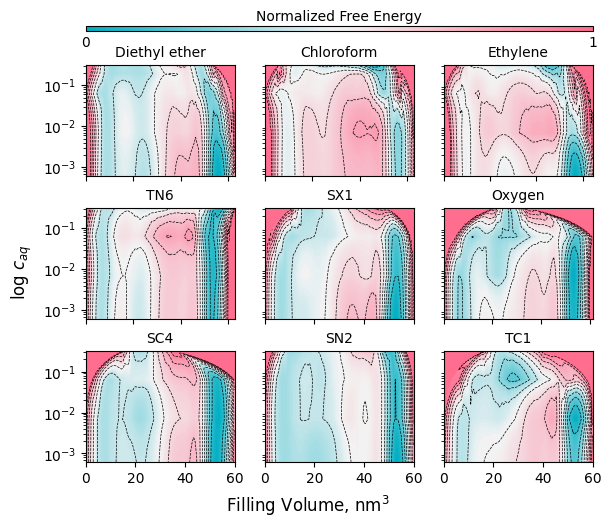

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import griddata
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Load and filter data
df = pd.read_csv(f'{ROOT}/FE/outfiles/FE_all.csv')
df = df[~df['mol'].isin(['No gas', 'Bare', 'Fullerene'])]
df = df[df['ngas'] != 0]
df = df[df['FE'] <= 30]

# Settings
molecules = ['Diethyl ether', 'Chloroform', 'Ethylene', 'TN6', 'SX1', 'Oxygen', 'SC4', 'SN2', 'TC1']
grid_res = 100

cmap = sns.diverging_palette(210, 1, l=65, center="light", s=100, sep=10, as_cmap=True, n=len(molecules))
cmap.set_over(cmap(1.0))
vmin = 0
vmax = 1

# Set up figure and GridSpec
fig = plt.figure(figsize=(6, 5), constrained_layout=True)
nrows = 4
ncols = 3
gs = gridspec.GridSpec(nrows=nrows, ncols=ncols, height_ratios=[0.1, 1, 1, 1], figure=fig)

# First row: empty axes for colorbar
cax = fig.add_subplot(gs[0, :])
cax.set_axis_off()

# Plotting
for i, mol in enumerate(molecules):
    ax = fig.add_subplot(gs[(i // ncols) + 1, i % ncols])
    subdf = df[df['mol'] == mol]

    x = subdf['coord'].values
    x -= x.min()
    y = subdf['C'].values
    z = subdf['FE'].values
    z = (z - z.min()) / (z.max() - z.min())

    xi = np.linspace(x.min(), x.max(), grid_res)
    yi = np.linspace(y.min(), y.max(), grid_res)
    xi, yi = np.meshgrid(xi, yi)
    zi = griddata((x, y), z, (xi, yi), method='linear', fill_value=vmax)

    im = ax.contourf(xi, yi, zi, levels=100, cmap=cmap, vmin=vmin, vmax=vmax)
    im2 = ax.contour(xi, yi, zi, levels=10, colors='xkcd:black', vmin=vmin, vmax=vmax,
                     linewidths=0.5, linestyles='--')

    ax.set_title(mol, fontsize=10)
    ax.set_yscale('log')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticks([0, 20, 40, 60], labels=['','','',''])

    # Remove y-axis ticks for second and third columns
    col = i % ncols
    if col in [1, 2]:
        ax.set_yticklabels([])
        ax.set_yticks([])

# Colorbar on top using make_axes_locatable
divider = make_axes_locatable(cax)
cax = divider.append_axes('top', size="95%")

# Shared colorbar
cbar = fig.colorbar(im, ax=cax, cax=cax, orientation='horizontal')
cbar.ax.tick_params(which='both', size=0)
cbar.ax.xaxis.set_label_position('top')
cbar.ax.set_xlabel('Normalized Free Energy', fontsize=10)
cbar.ax.set_xticks([0, 1], labels=['0', '1'])

# Final tweaks
fig.supylabel('log $c_{aq}$', fontsize=12)
fig.supxlabel(' Filling Volume, nm$^3$', fontsize=12)

# Set xticks only on bottom row
for ax in fig.axes[-4:-1]:
    ax.set_xticks([0, 20, 40, 60], labels=[0, 20, 40, 60])

# Save
fig.savefig(f'{ROOT}/FE/plots/FE_2d.png', dpi=300)

/scratch/rasera/venv/lib64/python3.11/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


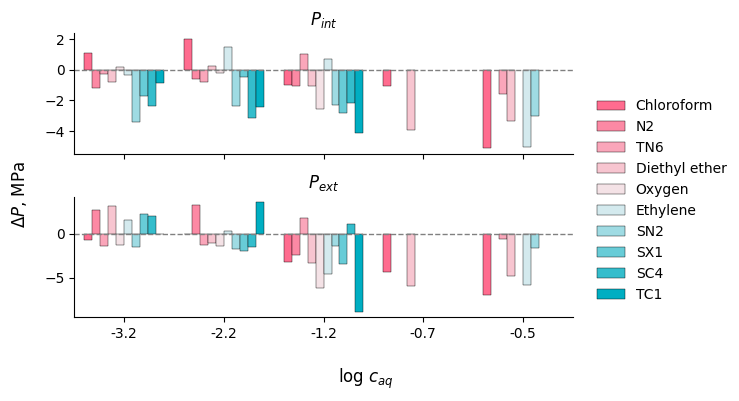

In [10]:
import seaborn as sns
import matplotlib.patches as mpatches

NGASES = [10,50,100,200,500,1000,2000,3000,5000]

SYS = "C8,1.2"
INC = "_inc_50"
KAPPA = 0.01

df = pd.read_csv(f"{ROOT}/FE/outfiles/Pint_Pext_all_{KAPPA}_{SYS}.csv")
df_nogas = df[df['mol']=='No gas']

df = df[~df['mol'].isin(['No gas', 'Bare', 'Fullerene'])]
df = df[df['ngas']!= 0]

df['$P_{int}$'] = df['Pint'] - df_nogas['Pint'].values
df['$P_{ext}$'] = df['Pext_barrier'] - df_nogas['Pext_barrier'].values
df = df[(abs(df['$P_{ext}$']) < 20) & (abs(df['$P_{int}$']) < 20)]

palette = sns.diverging_palette(1, 210, l=65, center="light", s=100, sep=1, as_cmap=False, n=len(df['mol'].unique()))

df = pd.melt(df, id_vars=['mol', 'ngas', 'C'], value_vars=['$P_{int}$', '$P_{ext}$'],
             var_name='Pressure_Type', value_name='Pressure')
df['log_c'] = np.log10(df['C']).round(1)

g = sns.FacetGrid(df, col="Pressure_Type", col_wrap=1, sharey=False, height=2, aspect=3)

g.map(sns.barplot,
      "log_c",
      "Pressure",
      hue="mol",
      data=df,
      palette=palette,
      saturation=1,
      edgecolor="black",
      linewidth=0.3 )

g.set_axis_labels("", "")
g.figure.supylabel("$\Delta P$, MPa")
g.figure.supxlabel("log $c_{aq}$")

col_mapping = {
    "Pint": r"$P_{int}$",
    "Pext": r"$P_{ext}$",
}
for ax, col_val in zip(g.axes.flat, g.col_names):
    ax.set_title(col_mapping.get(col_val, col_val))
g.add_legend()
g.refline(y=0, linestyle='--', color='gray', lw=1)

g.figure.savefig(f"{ROOT}/FE/plots/Pint_Pext_concentrations.png", dpi=300)

-2.9430765583011422
-9.898726082571928
0.17139838355567275
-7.922843950870589
-5.231331884784333
-4.787928325425645
-0.0800088113790306
-7.794981095666565
-0.9369702626729137
-9.702780044334075


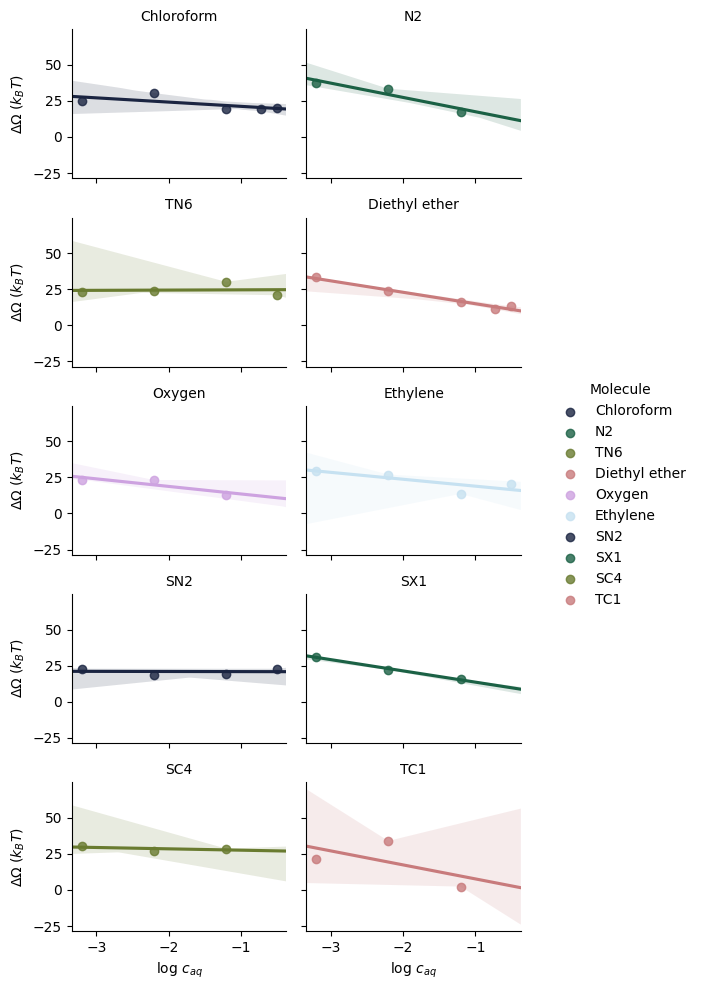

In [11]:
def regplot(
    *args,
    line_kws=None,
    marker=None,
    scatter_kws=None,
    **kwargs
):
    # this is the class that `sns.regplot` uses
    plotter = sns.regression._RegressionPlotter(*args, **kwargs)

    # this is essentially the code from `sns.regplot`
    ax = kwargs.get("ax", None)
    if ax is None:
        ax = plt.gca()

    scatter_kws = {} 
    scatter_kws["marker"] = marker
    line_kws = {}

    plotter.plot(ax, scatter_kws, line_kws)

    # unfortunately the regression results aren't stored, so we rerun
    grid, yhat, err_bands = plotter.fit_regression(plt.gca())

    # also unfortunately, this doesn't return the parameters, so we infer them
    slope = (yhat[-1] - yhat[0]) / (grid[-1] - grid[0])
    intercept = yhat[0] - slope * grid[0]
    print(slope)
    
    return slope, intercept


import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

NGASES = [10, 50, 100, 200, 500, 1000, 2000, 3000, 5000]
palette = sns.color_palette("cubehelix")

SYS = "C8,1.2"
INC = "_inc_50"
KAPPA = 0.01

df = pd.read_csv(f"{ROOT}/FE/outfiles/Pint_Pext_all_{KAPPA}_{SYS}.csv")
df = df[~df['mol'].isin(['No_gas', 'Bare', 'Fullerene'])]
df = df[df['ngas'] != 0]
df_nogas = df[df['mol'] == 'No_gas']
df['Delta_FE'] = abs(df['Delta_FE'])
df['log_c'] = np.log10(df['C'])

# Use FacetGrid to separate by molecule and plot regression
g = sns.FacetGrid(data=df, col="mol", hue="mol", col_wrap=2, palette=palette, height=2, aspect=1)
g.map_dataframe(regplot, x="log_c", y="Delta_FE", scatter=True, truncate=False)

# Set axis labels and titles
g.set_axis_labels("log $c_{aq}$", "$\Delta \Omega$ ($k_B T$)")
g.set_titles(col_template="{col_name}")
g.add_legend(title="Molecule", loc="center right", bbox_to_anchor=(1.3,0.5))

# Save figure
g.figure.tight_layout()
g.figure.savefig(f"{ROOT}/FE/plots/DeltaOmega_mols_reg.png", dpi=300)
plt.show()


/scratch/rasera/venv/lib64/python3.11/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


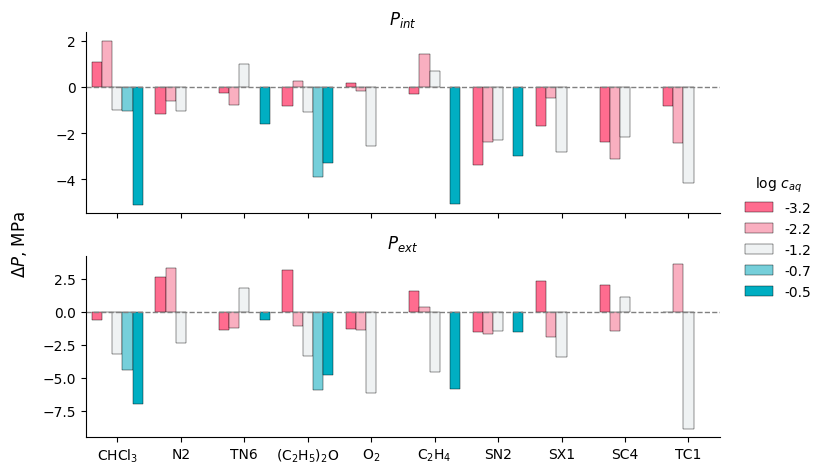

In [15]:
import seaborn as sns
import matplotlib.patches as mpatches

NGASES = [10,50,100,200,500,1000,2000,3000,5000]

SYS = "C8,1.2"
INC = "_inc_50"
KAPPA = 0.01

df = pd.read_csv(f"{ROOT}/FE/outfiles/Pint_Pext_all_{KAPPA}_{SYS}.csv")
df_nogas = df[df['mol']=='No gas']

df = df[~df['mol'].isin(['No gas', 'Bare', 'Fullerene'])]
df = df[df['ngas']!= 0]

df['$P_{int}$'] = df['Pint'] - df_nogas['Pint'].values
df['$P_{ext}$'] = df['Pext_barrier'] - df_nogas['Pext_barrier'].values
df = df[(abs(df['$P_{ext}$']) < 20) & (abs(df['$P_{int}$']) < 20)]

df['mol'] = df['mol'].replace(MOL_MAP)

df = pd.melt(df, id_vars=['mol', 'ngas', 'C'], value_vars=['$P_{int}$', '$P_{ext}$'],
             var_name='Pressure_Type', value_name='Pressure')
df['log_c'] = np.log10(df['C']).round(1)

palette = sns.diverging_palette(1, 210, l=65, center="light", s=100, sep=1, as_cmap=False, n=len(df['log_c'].unique()))

g = sns.FacetGrid(df, col="Pressure_Type", col_wrap=1, sharey=False, height=2.5, aspect=3)

g.map(sns.barplot,
      "mol",
      "Pressure",
      hue="log_c",
      data=df,
      palette=palette,
      saturation=1,
      edgecolor="black",
      linewidth=0.3 )

g.set_axis_labels("", "")
g.figure.supylabel("$\Delta P$, MPa")
g.figure.supxlabel("")

col_mapping = {
    "Pint": r"$P_{int}$",
    "Pext": r"$P_{ext}$",
}
for ax, col_val in zip(g.axes.flat, g.col_names):
    ax.set_title(col_mapping.get(col_val, col_val))

g.add_legend(title="log $c_{aq}$")
g.refline(y=0, linestyle='--', color='gray', lw=1)

g.figure.savefig(f"{ROOT}/FE/plots/Pint_Pext_mols.png", dpi=300)

In [16]:
exp_Pint = pd.DataFrame(EXP_PINT).T.reset_index()
exp_Pext = pd.DataFrame(EXP_PEXT).T.reset_index()
exp_Pint.columns=['T']+exp_Pint.columns[1:].tolist()
exp_Pext.columns=['T']+exp_Pext.columns[1:].tolist()

exp_Pint['Pressure_type'] = 'Pint'
exp_Pext['Pressure_type'] = 'Pext'

df = pd.concat([exp_Pext,exp_Pint])

# Melting the DataFrame
df_melted = df.melt(id_vars=["T", "Pressure_type"], 
                     var_name="mol", 
                     value_name="Pressure")

# Pivoting so that Pint and Pext become separate columns
df = df_melted.pivot(index=["T", "mol"], columns="Pressure_type", values="Pressure").reset_index()

# Rename columns for clarity
df.columns.name = None  # Remove the automatic column name
df.rename(columns={"Pint": "Pint", "Pext": "Pext"}, inplace=True)
df['C'] = df['mol'].map(CONC)
df['log_c'] = np.log10(df['C']).round(1)

nogas_pint = 18.962
nogas_pext = 1.32
df['Pint_norm'] = (df['Pint'] - nogas_pint)/df['log_c']
df['Pext_norm'] = (df['Pext'] - nogas_pext)/df['log_c']

df = pd.melt(df, id_vars=['T', 'mol', 'C'], value_vars=['Pint_norm', 'Pext_norm'],
                    var_name='Pressure_Type', value_name='Pressure')

df.to_csv(f'{ROOT}/FE/outfiles/exp_data.csv', index=False)


/scratch/rasera/venv/lib64/python3.11/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


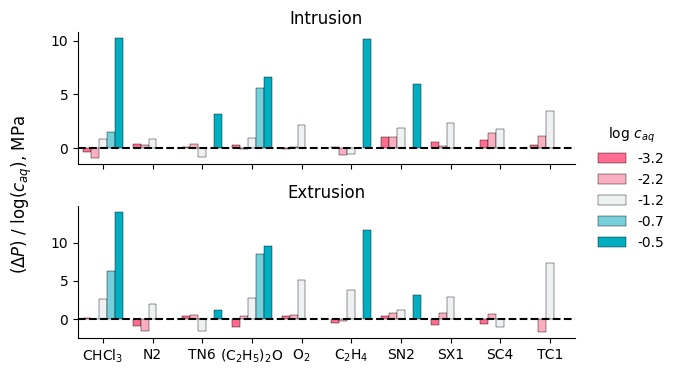

In [18]:
SYS = "C8,1.2"
INC = "_inc_50"
KAPPA = 0.01

df = pd.read_csv(f"{ROOT}/FE/outfiles/Pint_Pext_all_{KAPPA}_{SYS}.csv")
df_nogas = df[(df['mol']=='No gas')]
df = df[~df['mol'].isin(['No gas', 'Bare', 'Fullerene'])]
df = df[df['ngas']!= 0]
df['log_c'] = np.log10(df['C']).round(1)

cpore = pd.read_csv(f"{ROOT}/FE/outfiles/c_pore.csv")
cpore = cpore[~cpore['mol'].isin(['No gas', 'Bare', 'Fullerene'])]
cpore = cpore[cpore['ngas']!= 0]


df['mol_chem'] = df['mol'].replace(MOL_MAP)

df['$P_{int}$'] = df['Pint'] - df_nogas['Pint'].values
df['$P_{ext}$'] = df['Pext_barrier'] - df_nogas['Pext_barrier'].values
df = df[(abs(df['$P_{ext}$']) < 30) & (abs(df['$P_{int}$']) < 30)]

df['Pint_norm'] = df['$P_{int}$']/df['log_c']
df['Pext_norm'] = df['$P_{ext}$']/df['log_c']

#df = df[df.apply(lambda row: int(row['ngas']) == SELECTION.get(row['mol'], -1), axis=1)]

df = pd.melt(df, id_vars=['mol_chem', 'ngas', 'log_c'], value_vars=['Pint_norm', 'Pext_norm'], var_name='Pressure_Type', value_name='Pressure')
palette = sns.diverging_palette(1, 210, l=65, center="light", s=100, sep=1, as_cmap=False, n=len(df['log_c'].unique()))

#custom_order = ['(C$_2$H$_5$)$_2$O', 'CHCl$_3$', 'C$_2$H$_4$', 'SX1', 'SN2', 'Xe', 'N$_2$']
#df['mol_chem'] = pd.Categorical(df['mol_chem'], categories=custom_order, ordered=True)
    
g = sns.FacetGrid(df, col="Pressure_Type", col_wrap=1, sharey=False, height=2, aspect=3)

g.map(sns.barplot,
      "mol_chem",
      "Pressure",
      data=df,
      hue='log_c',
      palette=palette,
      saturation=1,
      edgecolor="black",
      linewidth=0.3 )

g.set_axis_labels("", "")
g.figure.supylabel("$(\\Delta P) \ / \  \\log(c_{aq})$, MPa")
g.figure.supxlabel("")
g.set_titles(col_template="{col_name}")
g.add_legend(title="log $c_{{aq}}$")

for ax in g.axes.flat:
    title = ax.get_title()
    title = title.replace('Pext_norm', 'Extrusion').replace('Pint_norm', 'Intrusion')
    ax.set_title(title)

g.figure.savefig(f"{ROOT}/FE/plots/Pint_Pext_mols.png", dpi=300)
g.refline(y=0, color='k', linestyle='--')

df.to_csv(f'{ROOT}/FE/outfiles/Pie_sim.csv', index=False)


/tmp/ipykernel_518281/3664322159.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mol_chem'] = pd.Categorical(df['mol_chem'], categories=custom_order, ordered=True)
/tmp/ipykernel_518281/3664322159.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Pressure_Type'] = pd.Categorical(df['Pressure_Type'], categories=pressure_type_order, ordered=True)
/scratch/rasera/venv/lib64/python3.11/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is li

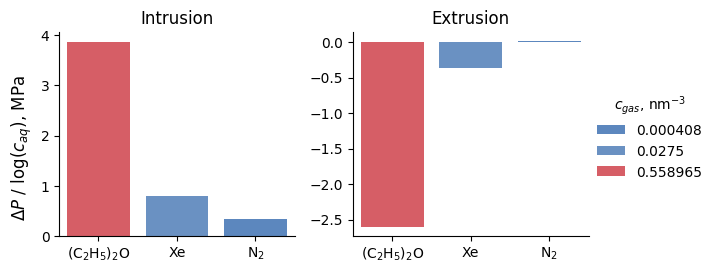

In [19]:
MOL_MAP_EXP = {
    'Nitrogen': 'N$_2$', 
    'Chloroform': 'CHCl$_3$', 
    'Ethylene': 'C$_2$H$_4$', 
    'Diethyl ether': '(C$_2$H$_5$)$_2$O',
    'Xenon': 'Xe',
    'Oxygen': 'O$_2$',
}

df_exp = pd.read_csv(f"{ROOT}/FE/outfiles/exp_data.csv")
df_exp = df_exp[df_exp['T'] == 25]

df_exp['mol_chem'] = df_exp['mol'].replace(MOL_MAP_EXP)
df = df_exp[(df_exp['mol_chem'] != 'Ar') & (df_exp['mol_chem'] != 'C$_2$H$_4$')]

custom_order = ['(C$_2$H$_5$)$_2$O', 'Xe', 'N$_2$']
df['mol_chem'] = pd.Categorical(df['mol_chem'], categories=custom_order, ordered=True)
pressure_type_order = ['Pint_norm', 'Pext_norm']
df['Pressure_Type'] = pd.Categorical(df['Pressure_Type'], categories=pressure_type_order, ordered=True)

df_sorted = df.sort_values(['Pressure_Type', 'mol_chem'])
df = df_sorted.reset_index(drop=True)
df['Pressure'] = df['Pressure'].round(2)

g = sns.FacetGrid(df, col="Pressure_Type", col_wrap=2, sharey=False)

g.map(sns.barplot,
      "mol_chem",
      "Pressure",
      hue='C',
      data=df,
      palette=sns.diverging_palette(250, 10, l=55, center="light", s=75, sep=5, as_cmap=True))

g.set_axis_labels("", "")
g.figure.supylabel("$\\Delta P \ / \  \\log(c_{aq})$, MPa")
g.figure.supxlabel("")
g.set_titles(col_template="{col_name}")
g.add_legend(title="$c_{{gas}}$, nm$^{{-3}}$")

for ax in g.axes.flat:
    title = ax.get_title()
    title = title.replace('Pext_norm', 'Extrusion').replace('Pint_norm', 'Intrusion')
    ax.set_title(title)

g.figure.savefig(f"{ROOT}/FE/plots/Pint_Pext_exp.png", dpi=300)
df.to_csv(f'{ROOT}/FE/outfiles/Pie_exp.csv', index=False)

Index(['mol_chem', 'ngas', 'log_c', 'Pressure_Type', 'Pressure'], dtype='object')


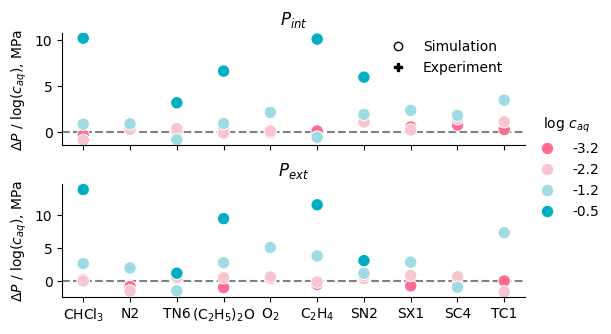

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

SELECTION = {'(C$_2$H$_5$)$_2$O':2000,
             'SX1':100,
             'C$_2$H$_4$':10,
             'Xe':100,
             'SN2':1000,
             'CHCl$_3$':1000,
             'N$_2$':10,
             'TN6':100
             }

# Load and label data
df1 = pd.read_csv(f'{ROOT}/FE/outfiles/Pie_sim.csv')
print(df1.columns)
df2 = pd.read_csv(f'{ROOT}/FE/outfiles/Pie_exp.csv')
df1['Source'] = 'Simulation'
df2['Source'] = 'Experiment'

#df1['mol_chem'] = df1['mol_chem'].replace('TC1', 'N$_2$')
#df1['mol_chem'] = df1['mol_chem'].replace('SX1', 'Xe')
#df1 = df1[df1.apply(lambda row: int(row['ngas']) == SELECTION.get(row['mol_chem'], -1), axis=1)]


df1 = pd.concat([df1, df2], ignore_index=True)
df1 = df1[df1['ngas'].isin([10, 100, 1000, 5000])]
df = pd.merge(df,df1)

# Order molecule categories
#custom_order = ['(C$_2$H$_5$)$_2$O', 'CHCl$_3$', 'Xe', 'C$_2$H$_4$', 'N$_2$']
#df['mol_chem'] = pd.Categorical(df['mol_chem'], categories=custom_order, ordered=True)

# Create FacetGrid WITHOUT hue
g = sns.FacetGrid(df, col="Pressure_Type", height=1.8, aspect=3, col_wrap=1, sharey=False, sharex=True)

# Plot simulation: line with error band (no manual color)
def plot_simulation(data, color=None, style='line', **kwargs):
    sim = data[data['Source'] == 'Simulation']
    if not sim.empty:

        if style == 'line':
            sns.lineplot(
                data=sim,x="mol_chem",y="Pressure",marker="s",
                linewidth=2,color="tab:blue",err_style="bars",
                sizes=100,**kwargs
            )
        else:
            palette = sns.diverging_palette(1, 210, l=65, center="light", s=100, sep=1, as_cmap=False, n=len(sim['log_c'].unique()))

            sns.scatterplot(data=sim,x="mol_chem",y="Pressure",
                marker="o",hue="log_c", palette=palette,
                s=80, legend=True, **kwargs
            )

# Plot experiment: scatter (no manual color)
def plot_experiment(data, color=None, **kwargs):
    exp = data[data['Source'] == 'Experiment']
    if not exp.empty:
        sns.scatterplot(data=exp,x="mol_chem",y="Pressure",
            marker="P",color="black",s=80,**kwargs
        )

# Apply both to FacetGrid
g.map_dataframe(plot_simulation, zorder=1, style='scatter')
g.map_dataframe(plot_experiment, zorder=2)
g.refline(y=0, zorder=-1)

# Customize labels/titles
g.set_axis_labels("", "$\Delta P$ / log($c_{aq}$), MPa")
g.axes[0].set_title('$P_{int}$')
g.axes[1].set_title('$P_{ext}$')

# Custom legend
custom_lines = [
    Line2D([0], [0], markerfacecolor='white', markeredgecolor='black', marker='o', lw=0, label='Simulation'),
    Line2D([0], [0], color='black', marker='P', lw=0, label='Experiment')
]
g.figure.legend(handles=custom_lines, bbox_to_anchor=(0.85,0.92), 
                loc='upper right', frameon=False)
g.add_legend(title='log $c_{aq}$')

# Save plot
g.figure.savefig(f'{ROOT}/FE/plots/Pint_Pext_combined.png', dpi=300)


In [80]:
SYS = "C8,1.2"
INC = "_inc_50"
KAPPA = 0.01
NGASES = [0,2,10,50,100,200,500,1000,2000,3000,4000,5000]

dfs = []
for MOL in tqdm(MOLS[:]):
    GAS = GASES[MOL]
    for NGAS in NGASES:
        try:
            df = pd.read_csv(f"{ROOT}/FE/outfiles/ngas_{MOL}_{NGAS}.csv")
            if MOL == "Fullerene":
                df['av_gas'] = df['av_gas']/15
                df['std_gas'] = df['std_gas']/15
        except:
            continue
        
        df['mol'] = df['mol'].apply(lambda x: x.replace("_"," "))
        df['vol'] = df['coord'] * 2.99e-2
        df['C'] = df['ngas']/(2*20**3)
        df['log_c'] = df['C'].apply(lambda x: np.log10(x)).round(1)
        dfs.append(df)

dfout = pd.concat(dfs, ignore_index=True)
dfout.to_csv(f"{ROOT}/FE/outfiles/NGAS_all.csv",index=False)

dfout

  0%|          | 0/11 [00:00<?, ?it/s]

,mol,natoms,nwater,ngas,coord,vol,C,log_c,av_ngas,std_gas,av_nwater,std_water
0,Chloroform,0.0,1955.0,10,10500,313.950,0.000625,-3.2,NaN,NaN,NaN,NaN
1,Chloroform,0.0,2013.0,10,10550,315.445,0.000625,-3.2,NaN,NaN,NaN,NaN
2,Chloroform,0.0,2019.0,10,10600,316.940,0.000625,-3.2,NaN,NaN,NaN,NaN
3,Chloroform,0.0,2066.0,10,10650,318.435,0.000625,-3.2,NaN,NaN,NaN,NaN
4,Chloroform,0.0,2071.0,10,10700,319.930,0.000625,-3.2,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
326,SX1,177.0,1963.0,1000,10800,322.920,0.062500,-1.2,NaN,NaN,NaN,NaN
327,SX1,167.0,1990.0,1000,10850,324.415,0.062500,-1.2,NaN,NaN,NaN,NaN
328,SX1,197.0,1951.0,1000,10900,325.910,0.062500,-1.2,NaN,NaN,NaN,NaN
329,SX1,179.0,2032.0,1000,10950,327.405,0.062500,-1.2,NaN,NaN,NaN,NaN


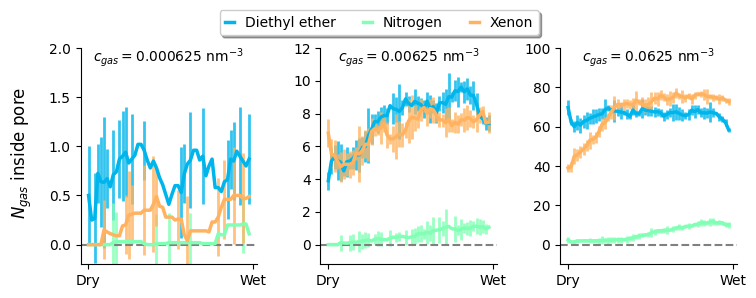

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Sample data loading
df_read = pd.read_csv(f"{ROOT}/FE/outfiles/NGAS_all.csv")
palette = sns.color_palette("rainbow", n_colors=3)

df = df_read.sort_values(["mol", "ngas", "coord"])  # Ensure sorted data
df = df[(df['ngas'] != 2) & (df['ngas'] != 0)]  # Exclude unwanted N_gas values
df = df[~df['mol'].isin(['No gas', 'Bare', 'Chloroform', 'Ethylene', 'Oxygen', 'Fullerene'])]
df['av_ngas_smooth'] = df.groupby(['ngas', 'mol'])['av_ngas'].transform(lambda x: x.rolling(window=10, min_periods=1).mean())
df['av_nw_smooth'] = df.groupby(['ngas', 'mol'])['av_nwater'].transform(lambda x: x.rolling(window=10, min_periods=1).mean())

# Create a FacetGrid where each panel represents a molecule
g = sns.FacetGrid(df, col="C", col_wrap=3, sharey=False, height=3, aspect=0.5)

# Map the smoothed time series plot to each facet
g.map_dataframe(sns.lineplot,  x="vol", y="av_ngas_smooth", alpha=1,
                hue="mol", palette=palette, lw=2.5)

for ax, (ngas, subset), ylim in zip(g.axes.flat, df.groupby("C"), [(-0.2,2),(-1.2,12),(-10,100)]):
    i = 0
    ax.set_ylim(ylim)
    ax.set_xticks([245,325])
    ax.set_xticklabels(['Dry','Wet'])
    ax.set_title("")
    for mol, mol_subset, in subset.groupby("mol"):
        color = palette[i]
        ax.errorbar(mol_subset["vol"], mol_subset["av_ngas_smooth"], 
                    yerr=mol_subset["std_gas"], fmt='none', 
                    elinewidth=2, alpha=0.8, color=color, zorder=-5)
        i+=1

# Adjust layout and add legend
g.add_legend(loc='upper center', ncols=4, handlelength=0.6, fontsize=10,
             bbox_to_anchor=(0.5, 1.0), frameon=True, fancybox=True, shadow=True)
g.set_axis_labels("", "")
g.figure.supylabel("$N_{gas}$ inside pore", x=0.02)
g.set_titles(col_template="$c_{{gas}}=${col_name} nm$^{{-3}}$", loc='center', y=0.9)
g.refline(y=0, zorder=-5, ls='--', lw=1.5)

g.figure.tight_layout()
g.figure.subplots_adjust(top=0.85)
g.figure.savefig(f'{ROOT}/FE/plots/Ngas_all.png', dpi=300)


/scratch/rasera/venv/lib64/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


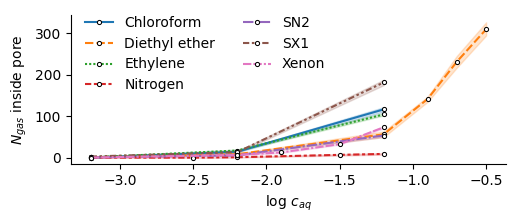

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Sample data loading
df_read = pd.read_csv(f"{ROOT}/FE/outfiles/NGAS_all.csv")
palette = sns.diverging_palette(1, 210, l=65, center="light", s=100, sep=1, as_cmap=False)

df = df_read.sort_values(["mol", "ngas", "coord"])  # Ensure sorted data
df = df[(df['ngas'] != 2) & (df['ngas'] != 0)]  # Exclude unwanted N_gas values
df = df[~df['mol'].isin(['No gas', 'Bare', 'Oxygen', 'Fullerene'])]

# Create a FacetGrid where each panel represents a molecule
g = sns.FacetGrid(df, sharey=False, height=2.5, aspect=1.1)

# Map the smoothed time series plot to each facet
g.map_dataframe(sns.lineplot,  x="log_c", y="natoms", alpha=1,
                hue="mol", palette='tab10', style="mol", marker='o',
                markersize=3, markeredgecolor='black', markerfacecolor='white')

# Adjust layout and add legend
g.add_legend(loc='upper center', ncols=2, fontsize=10,
             bbox_to_anchor=(0.4, 0.9), frameon=False, fancybox=False, shadow=False)
g.set_axis_labels("log $c_{aq}$", "$N_{gas}$ inside pore")

g.figure.tight_layout()
g.figure.subplots_adjust(top=0.85)
g.figure.savefig(f'{ROOT}/FE/plots/Ngas_all.png', dpi=300)

mean = df.groupby(['mol','ngas'])['natoms'].mean().reset_index()
mean['C_pore'] = mean['natoms'].values / (20*2*np.pi**2)
mean['log_cpore'] = np.log10(mean['C_pore'])
mean.to_csv(f"{ROOT}/FE/outfiles/c_pore.csv", index=False)

In [ ]:
def is_contour_within_radius(contour_line, center, radius):
    # Calculate the distance of each point in the contour line from the center
    distances = np.sqrt((contour_line[:, 0] - center[0])**2 + (contour_line[:, 1] - center[1])**2)
    # Return True if any point in the contour line is within the radius
    return np.any(distances <= radius)


from MDAnalysis.analysis.density import DensityAnalysis
from scipy.stats import gaussian_kde

MOL = "Chloroform"
SYS = "C8,1.2"
KAPPA = 0.01
COLORS = ["xkcd:tomato", "xkcd:amber", "xkcd:violet", "xkcd:water blue"]
NGAS = 100

print(f"{ROOT}/FE/{MOL}/{SYS}/{NGAS}/{KAPPA}/CV_water_gas{INC}/*part*.gro")
gro = natsorted(glob.glob(f"{ROOT}/FE/{MOL}/{SYS}/{NGAS}/{KAPPA}/CV_water_gas{INC}/*full*.gro"))[-1]
xtc = natsorted(glob.glob(f"{ROOT}/FE/{MOL}/{SYS}/{NGAS}/{KAPPA}/CV_water_gas{INC}/*part*.xtc"))[-1]
u = mda.Universe(gro,xtc)
nframes = len(u.trajectory)

radius = 19.5
radius_squared = radius ** 2
silanes = u.select_atoms("resname SIL") 
bulk = u.select_atoms("resname BULK")
gases = u.select_atoms(f"resname {GAS}")
center = u.select_atoms("resname SIL").positions.mean(axis=0)[:2]+np.array([0,0])

distances = np.linalg.norm((silanes.positions[:,:2] - center), axis=1)
indices_within_cutoff = np.where(distances <= radius)[0]
silanes = silanes[indices_within_cutoff]

D = DensityAnalysis(silanes, delta=1)
D.run(step=1,verbose=True)
density = np.mean(D.density.grid, axis=2)

plt.imshow(density)
contour = plt.contour(density, levels=[0.001], colors='black', alpha=0)

for contour_line in contour.allsegs:
    for line in contour_line:
        if is_contour_within_radius(line, [20,20], 16):
            print("yes")
            plt.plot(line[:, 0], line[:, 1], color='red')



In [ ]:
from scipy.stats import gaussian_kde
from scipy.integrate import trapezoid

def polar_dens(positions, ax, c="red", bw=0.05):
    angles = np.arctan2(positions[:, 1]-center[1], positions[:, 0]-center[0])
    angles = np.concatenate([angles - 2*np.pi, angles, angles + 2*np.pi])
    print(np.min(angles), np.max(angles))

    kde = gaussian_kde(angles, bw_method=bw)
    angle_grid = np.linspace(-np.pi, np.pi, 1000)
    density = kde(angle_grid)
    area = trapezoid(density, angle_grid) 
    normalized_density = density / area  

    ax.plot(angle_grid, normalized_density, color=c, lw=2)
    ax.set_xlabel("Angle (degrees)")
    ax.set_ylim(max(normalized_density), 0)
    #ax.yaxis.set_major_locator(plt.MaxNLocator(4))

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

polar_dens(silanes.positions[:, :2], ax, c="red", bw=0.02)
polar_dens(gases.positions[:, :2], ax, c="blue", bw=0.02)
